# Preparations

## Imports

In [1]:
!pip -q install anthropic==0.7.8
!pip -q install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.0/808.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00


In [1]:
import json
import os
import re
import sys

import numpy as np
import pandas as pd
from google.colab import drive
from IPython.core.display import HTML, display
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [ ]:
from anthropic import AI_PROMPT, HUMAN_PROMPT, Anthropic
from dotenv import load_dotenv

In [7]:
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
ROOT = "/content/drive/MyDrive/ai-detect"
sys.path.append(ROOT)

## Utils

In [2]:
def pretty_print(text):
    paragraphs = [f"<p>{paragraph}</p>" for paragraph in text.split("\n")]
    html = f'<div>{" ".join(paragraphs)}</div>'
    display(HTML(html))

## Prepare prompts

Загрузим тексты из оригинального датасета: эссе, которые писали студенты согласно инструкциям из задания, а так же сами задания.

In [17]:
train_promts = pd.read_csv(os.path.join(ROOT, "train_prompts.csv"))
train_essays = pd.read_csv(os.path.join(ROOT, "train_essays.csv"))

In [18]:
train_promts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


Таких заданий всего два. Будем генерировать тексты для второго из них (т.к. для первого уже есть).

In [19]:
PROMPT_ID = 1

In [20]:
instructions = train_promts.loc[PROMPT_ID].instructions
instructions

'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'

В задании нужно написать эссе по тексту. Посмотрим на сам текст.

In [21]:
source_text = train_promts.loc[PROMPT_ID].source_text
pretty_print(source_text)

Загрузим заранее подговленный шаблон промпта к LLM.

In [22]:
with open("template.txt") as f:
    template = f.read()

In [23]:
print(template)

You are a student passing an exam. Your task is to write an essay, following this <prompt>:

<prompt> {prompt} </prompt>

The essay must be based on the <text>:

<text> {text} </text>

Go straight to the answer; skip the preambule and do not write any introductions like 'Here is a draft essay responding to the prompt'. This is very important.

Please put your essay in <essay></essay> tags.

Assistant: <essay>


Будем просить модель притвориться учеником на экзамене и написать эссе в тегах <essay>.

# Cluade Dataset Generation

In [ ]:
# обращаемся к API, используя токен

load_dotenv()
claude_key = os.environ.get("CLAUDE_TOKEN")


anthropic = Anthropic(
    api_key=claude_key,
)

In [4]:
def generate_prompt(instructions: str, source_text: str, template: str) -> str:
    prompt = template.format(prompt=instructions, text=source_text)
    return f"{HUMAN_PROMPT}{prompt}"


def generate_essay(
    idx: int,
    prompt: str = "",
    instructions: str = "",
    source_text: str = "",
    template: str = "",
) -> str:
    if len(prompt) == 0:
        prompt = generate_prompt(instructions, source_text, template)

    # добавим разнообразия меняя температуру генерации
    if idx % 2 == 0:
        t = 1.0
    elif idx % 3 == 0:
        t = -1
    else:
        t = 0.0

    completion = anthropic.completions.create(
        model="claude-2.1", max_tokens_to_sample=700, prompt=prompt, temperature=t
    )

    return completion.completion

In [ ]:
NUM_ESSAYS = 250
generated_essays = []
for i, human_essay in enumerate(
    tqdm(
        train_essays.query(f"prompt_id=={PROMPT_ID}")["text"].sample(NUM_ESSAYS).values
    )
):
    # при генерации используем перевое слово из оригинальных текстов.
    # так генерации модели будут более разнообразными
    first_word = human_essay.split(" ")[0]
    prompt = generate_prompt(instructions, source_text, template) + first_word
    generated_essay = f"{first_word} {generate_essay(i, prompt=prompt)}"
    generated_essays.append(generated_essay)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
# удаляем теги, которыми LLM завершает эссе
generated_essays = [text.replace("</essay>", "") for text in generated_essays]

In [ ]:
all_generated_essays = []
GENERATED_DATA_PATH = os.path.join(ROOT, "generated_essays_1.json")
if os.path.exists(GENERATED_DATA_PATH):
    with open(os.path.join(ROOT, GENERATED_DATA_PATH), "r") as jf:
        all_generated_essays = json.load(jf)

In [ ]:
all_generated_essays.extend(generated_essays)
with open(os.path.join(ROOT, GENERATED_DATA_PATH), "w") as jf:
    json.dump(all_generated_essays, jf)

# EDA

## Uniting real and synt data

In [47]:
GENERATED_DATA_PATH = os.path.join(ROOT, "generated_essays_1.json")
with open(os.path.join(ROOT, GENERATED_DATA_PATH), "r") as jf:
    all_generated_essays = json.load(jf)

In [48]:
len(all_generated_essays)

755

In [49]:
import pandas as pd

synt_texts_df = pd.DataFrame(all_generated_essays)
synt_texts_df = synt_texts_df.rename(columns={synt_texts_df.columns[0]: "text"})
synt_texts_df["id"] = synt_texts_df.index
synt_texts_df = synt_texts_df.assign(prompt_id=0)
synt_texts_df = synt_texts_df.assign(generated=1)
synt_texts_df.head()

,text,id,prompt_id,generated
0,Americans have debated whether to abolish or ...,0,0,1
1,Voting is a fundamental right in a democracy....,1,0,1
2,"Dear State Senator,\n\nI am writing to argue ...",2,0,1
3,After reviewing the arguments for and against...,3,0,1
4,"Dear State Senator,\nI am writing regarding t...",4,0,1


In [50]:
train_essays = train_essays.query(f"prompt_id=={PROMPT_ID}")
train_essays.head()

,id,prompt_id,text,generated
5,00da8c32,1,The electrol college system is an unfair syste...,0
6,011dc2bc,1,"Dear state senator, It is the utmost respect t...",0
8,01c6e176,1,"""It's official: The electoral college is unfai...",0
9,0202ddf9,1,The Electoral College has been kept for centur...,0
10,020a5d6d,1,"Dear senator, Retain the Electoral College. Th...",0


In [51]:
data = pd.concat((synt_texts_df, train_essays))

In [52]:
data.groupby(["generated"]).agg({"text": "count"})

,text
generated,
0,668
1,757


## Text length

In [53]:
def count_texts_lengths(df):
    df["len"] = df.text.apply(lambda x: len(x.split()))

In [54]:
count_texts_lengths(data)

In [55]:
data.groupby(["generated"]).agg({"len": "mean"})

,len
generated,
0,536.733533
1,281.885073


**Сгенерированные тексты в среднем почти в 2 раза короче.** Интересно, что несколько, попавших в оригинальный датасет тоже были короткими, 200-300 слов (см. ноутбук с EDA для первого задания).

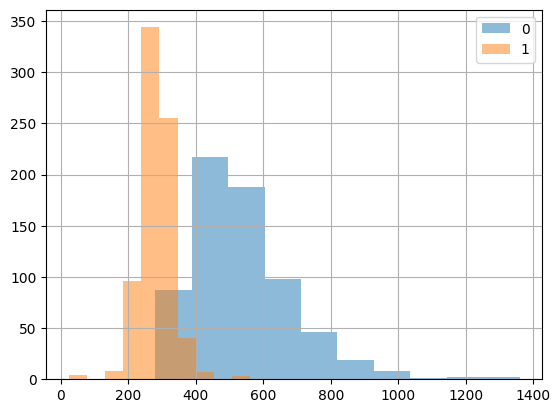

In [56]:
data.groupby(["generated"]).len.hist(legend=True, alpha=0.5);

## Frequent words

In [31]:
import string

import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

stopwords = stopwords.words("english")
stopwords.extend(string.punctuation)
stopwords.extend(["“", "”", "’", "``", "''", "'s", "n't"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [40]:
from collections import Counter


def tokenize(text):
    return nltk.word_tokenize(text.lower())


def get_all_words(texts, remove_stopwords=True):
    all_words = []
    for text in texts:
        if remove_stopwords:
            words = [word for word in tokenize(text) if word not in stopwords]
        else:
            words = tokenize(text)
        all_words.extend(words)
    return all_words


def find_frequent_words(words, k=20):
    n = len(words)
    freqs = Counter(words)
    for word in freqs:
        freqs[word] = round(freqs[word] / n, 2)
    return freqs.most_common(k)

In [38]:
frequent_words = pd.DataFrame(
    {
        "original": find_frequent_words(
            get_all_words(data[data.generated == 0].text.values)
        ),
        "synt": find_frequent_words(
            get_all_words(data[data.generated == 1].text.values)
        ),
        "all": find_frequent_words(get_all_words(data.text.values)),
    }
)
frequent_words

,original,synt,all
0,"(electoral, 0.04)","(electoral, 0.04)","(electoral, 0.04)"
1,"(college, 0.03)","(college, 0.03)","(college, 0.03)"
2,"(vote, 0.03)","(vote, 0.03)","(vote, 0.03)"
3,"(people, 0.02)","(states, 0.03)","(system, 0.02)"
4,"(president, 0.02)","(system, 0.02)","(popular, 0.02)"
5,"(states, 0.02)","(candidates, 0.02)","(president, 0.02)"
6,"(system, 0.01)","(popular, 0.02)","(states, 0.02)"
7,"(voting, 0.01)","(winner, 0.01)","(one, 0.01)"
8,"(electors, 0.01)","(elections, 0.01)","(candidates, 0.01)"
9,"(candidate, 0.01)","(win, 0.01)","(election, 0.01)"


Ничего необычного не вижу. Возможно, это потому что мы удалили стоп-слова, а в них могло быть самое интересное. Наример, при разметке выяснилось, что в текстах, написанных людьми, чаще встречаются личные местоимения.

In [43]:
def count_some_words(text, target_words=[]):
    words = tokenize(text)
    n = len(words)
    words = [word for word in words if word in target_words]
    return len(words) / n

In [61]:
PRONOUNS = [
    "i",
    "me",
    "you",
    "he",
    "she",
    "it",
    "him",
    "her",
    "we",
    "us",
    "they",
    "them",
]
data["pers_pronouns_per_text"] = data.text.apply(
    lambda x: count_some_words(x, target_words=PRONOUNS)
)
data["we_per_text"] = data.text.apply(
    lambda x: count_some_words(x, target_words=["we"])
)

In [62]:
data.groupby("generated").mean()[["pers_pronouns_per_text", "we_per_text"]]

<ipython-input-62-aad09fb5bbdf>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('generated').mean()[['pers_pronouns_per_text', 'we_per_text']]


,pers_pronouns_per_text,we_per_text
generated,,
0,0.039239,0.006063
1,0.028573,0.001023


Модель реже использует **личные местоимения**, особенно местоимение `we`.

## Text statistics (num chars, syllables, words, etc.)

При EDA в первом задании выяснилось, что в сгенерированных текстах используются более длинные слова. Проверим, выполнится ли это сейчас.

In [25]:
!pip -q install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.4 MB/s eta 0:00:00


In [50]:
from copy import deepcopy

import textstat


def count_textstats(df0):
    df = deepcopy(df0)
    df["chars"] = df.text.apply(textstat.char_count)
    df["lexicon"] = df.text.apply(textstat.lexicon_count)
    df["syllables"] = df.text.apply(textstat.syllable_count)
    df["sents"] = df.text.apply(textstat.sentence_count)
    df["avg_sent_len"] = df.text.apply(textstat.avg_sentence_length)
    df["avg_syl_per_word"] = df.text.apply(textstat.avg_syllables_per_word)
    df["avg_letter_per_word"] = df.text.apply(textstat.avg_letter_per_word)
    df["avg_sent_per_word"] = df.text.apply(textstat.avg_sentence_per_word)
    return df

In [51]:
from math import ceil


def compare_distibutions(grouped_df, features, num_cols=3, figsize=(10, 9), pad=1):
    fig, ax = plt.subplots(
        ceil(len(features) / 3), num_cols, figsize=figsize, squeeze=False
    )
    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        grouped_df[feature].hist(ax=ax[row, col], alpha=0.5)
        ax[row, col].set_title(feature)
    fig.legend(grouped_df.groups.keys())
    fig.tight_layout(pad=1)
    plt.show()

In [52]:
textstats_df = count_textstats(data)

In [53]:
textstats_df.corr().generated

<ipython-input-53-dd062deaadfd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  textstats_df.corr().generated


prompt_id             -0.997186
generated              1.000000
len                   -0.758986
chars                 -0.691858
lexicon               -0.758945
syllables             -0.691555
sents                 -0.572498
avg_sent_len          -0.428578
avg_syl_per_word       0.806210
avg_letter_per_word    0.851679
avg_sent_per_word      0.494679
Name: generated, dtype: float64

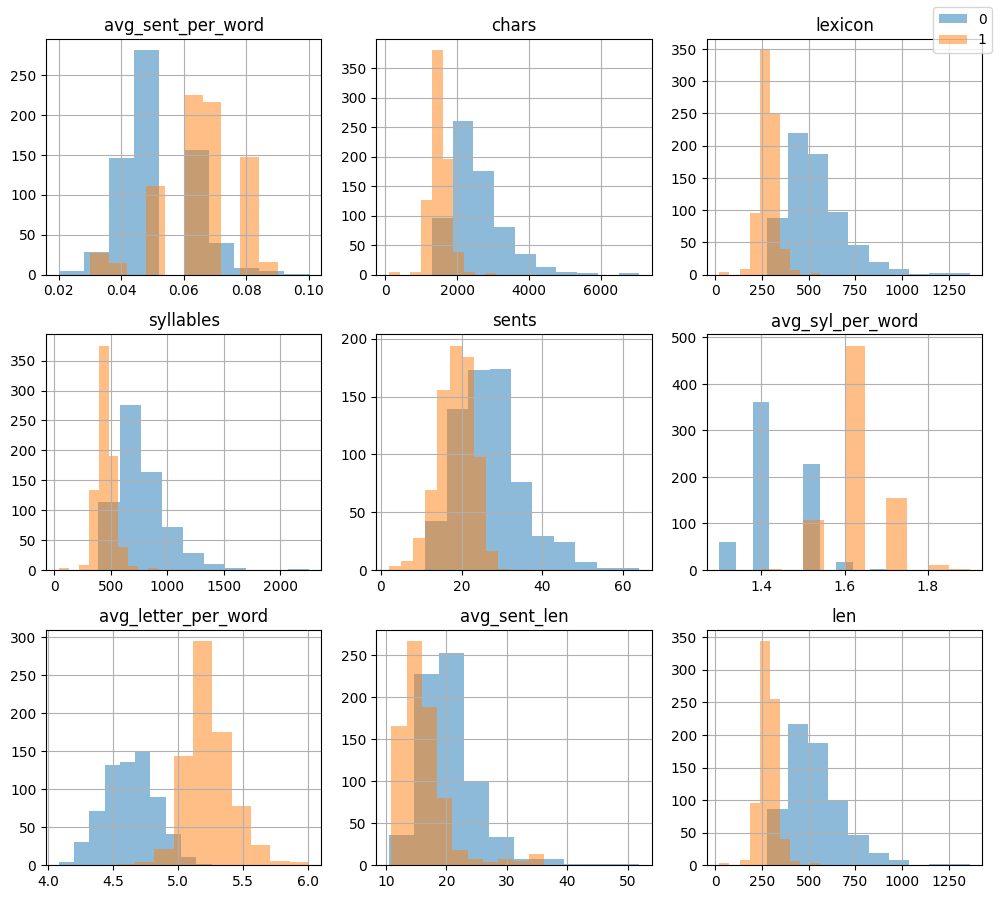

In [54]:
features = set(textstats_df.columns) - {"id", "prompt_id", "text", "generated", "title"}
compare_distibutions(textstats_df.groupby("generated"), features)

Да, **слова** в сгенерированных текстах действительно в среднем **длиннее**(см. `avg_letter_per_word`).

Еще из наблюдений: **предложения** в сгенерированных текстах, наоборот, в среднем **короче**, а самих предложений **меньше**. В первом EDA такого не было.

При разметке для второго задания, выяснилось, что в сгенерированных текстах все абзацы визуально одинаковой длины. Попробуем подтвердить это количественно.

In [55]:
def char_per_paragraph_variance(text):
    paragraphs = text.split("\n")
    paragraph_lens = [len(p) for p in paragraphs]
    return np.var(paragraph_lens)


def tokens_per_paragraph_variance(text):
    paragraphs = text.split("\n")
    paragraph_lens = [len(p.split(" ")) for p in paragraphs]
    return np.var(paragraph_lens)

In [56]:
textstats_df["char_per_paragraph_variance"] = data.text.apply(
    char_per_paragraph_variance
)
textstats_df["tokens_per_paragraph_variance"] = data.text.apply(
    tokens_per_paragraph_variance
)

In [57]:
textstats_df.corr().generated

<ipython-input-57-dd062deaadfd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  textstats_df.corr().generated


prompt_id                       -0.997186
generated                        1.000000
len                             -0.758986
chars                           -0.691858
lexicon                         -0.758945
syllables                       -0.691555
sents                           -0.572498
avg_sent_len                    -0.428578
avg_syl_per_word                 0.806210
avg_letter_per_word              0.851679
avg_sent_per_word                0.494679
char_per_paragraph_variance     -0.532698
tokens_per_paragraph_variance   -0.560348
Name: generated, dtype: float64

Корреляция не такая большая как ожидалось, но все-таки есть.

## Repetitions

Еще при разметке мы заметили, что у в человеческих текстах всречаются случайные повторения одно слова подряд. Исследуем этот признак.

In [132]:
def count_repetitions(text):
    num_repetitions = 0
    tokenized_text = tokenize(text)
    for i in range(1, len(tokenized_text)):
        if (
            tokenized_text[i] == tokenized_text[i - 1]
            and tokenized_text[i] not in string.punctuation
        ):
            num_repetitions += 1
    return num_repetitions

In [133]:
textstats_df["num_repetitions"] = data.text.apply(count_repetitions)

In [134]:
textstats_df[textstats_df["num_repetitions"] > 0][
    ["generated", "num_repetitions"]
].groupby("generated").count()

,num_repetitions
generated,
0,114
1,1


Повторения встречаются почти исключительно только у людей.